<a href="https://colab.research.google.com/github/RedaRafi/tensorflow/blob/master/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Segmentation d'image Travail Fait Par REDA RAFI USMBA MSID 
[LinkeDin](https://www.linkedin.com/in/reda-r-074884a9/)
[GitHub](https://github.com/RedaRafi)



### 1.   Introduction





Une image est un moyen de transférer des informations,
et l'image contient beaucoup d'informations utiles. Comprendre l'image et extraire des informations de
l'image pour accomplir certains travaux est un important
domaine d’application de la technologie de l’image numérique et
la première étape dans la compréhension de l'image est la segmentation de l'image. En pratique, il n’est souvent pas intéressé par tous
certaines parties de l'image, mais uniquement pour certaines zones
qui ont les mêmes caractéristiques. La segmentation d'image est l'un des points chauds du traitement d'image et
vision par ordinateur. C'est aussi une base importante pour l'image
reconnaissance. Il est basé sur certains critères pour
l'image d'entrée dans un certain nombre de la même nature de la
catégorie afin d'extraire la zone où les gens sont
intéressé. Et il est la base de l'analyse d'image et
compréhension de l'extraction et de la reconnaissance des caractéristiques de l'image *italicized text* 







## 2. importation des dataSets  









In [0]:
pip install -q git+https://github.com/tensorflow/examples.git

In [0]:
pip install -q -U tfds-nightly

     |████████████████████████████████| 3.3MB 2.8MB/s 





### 3.   Importation des Librairie



In [0]:
import tensorflow as tf

In [0]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [0]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete49TYLM/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete49TYLM/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


### 4. augmentation du retour d'une image




Le code suivant effectue une simple augmentation du retour d'une image. De plus, l'image est normalisée à [0,1]. Enfin, comme mentionné ci-dessus, les pixels du masque de segmentation sont étiquetés {1, 2, 3}. Par souci de commodité, soustrayons 1 du masque de segmentation, ce qui donne des étiquettes qui sont: {0, 1, 2}.

In [0]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [0]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

L'ensemble de données contient déjà les divisions requises de test et de formation et continuons donc à utiliser la même division.

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [0]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Jetons un coup d'œil à un exemple d'image et son masque correspondant de l'ensemble de données.

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

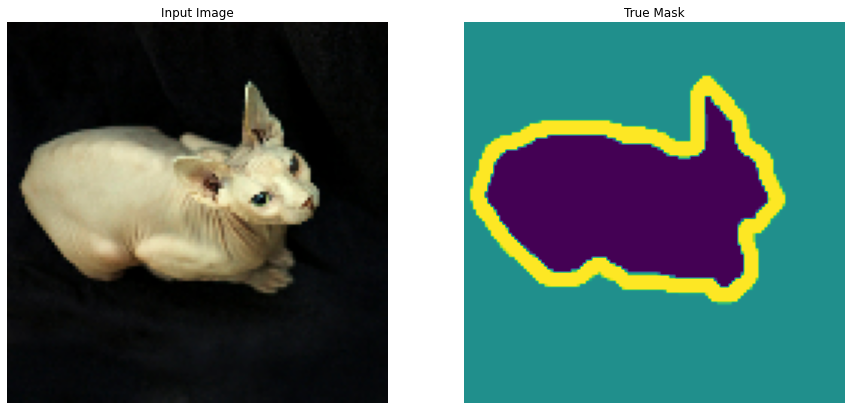

In [0]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

### 5.Définir le modèle

Le modèle utilisé ici est un U-Net modifié. Un U-Net se compose d'un encodeur (sous-échantillonneur) et d'un décodeur (sur-échantillonneur). Afin d'apprendre des fonctionnalités robustes et de réduire le nombre de paramètres pouvant être entraînés, un modèle pré-formé peut être utilisé comme encodeur. Ainsi, l'encodeur pour cette tâche sera un modèle MobileNetV2 pré-formé, dont les sorties intermédiaires seront utilisées, et le décodeur sera le bloc de suréchantillonnage déjà implémenté dans les exemples TensorFlow du didacticiel Pix2pix .

La raison de la sortie de trois canaux est qu'il existe trois étiquettes possibles pour chaque pixel. Considérez cela comme une multi-classification où chaque pixel est classé en trois classes.

In [0]:
OUTPUT_CHANNELS = 3

Comme mentionné, l'encodeur sera un modèle MobileNetV2 pré-formé qui est préparé et prêt à l'emploi dans tf.keras.applications . L'encodeur se compose de sorties spécifiques des couches intermédiaires du modèle. Notez que l'encodeur ne sera pas formé pendant le processus de formation.

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


Le décodeur / suréchantillonneur est simplement une série de blocs de suréchantillonnage implémentés dans les exemples TensorFlow.

In [0]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [0]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

###6.Former le modèle

Maintenant, tout ce qui reste à faire est de compiler et de former le modèle. La perte utilisée ici est losses.SparseCategoricalCrossentropy(from_logits=True). La raison d'utiliser cette fonction de perte est que le réseau essaie d'affecter à chaque pixel une étiquette, tout comme la prédiction multi-classe. Dans le vrai masque de segmentation, chaque pixel a soit un {0,1,2}. Le réseau émet ici trois canaux. Essentiellement, chaque canal essaie d'apprendre à prédire une classe et losses.SparseCategoricalCrossentropy(from_logits=True)constitue la perte recommandée pour un tel scénario. En utilisant la sortie du réseau, l'étiquette attribuée au pixel est le canal avec la valeur la plus élevée. C'est ce que fait la fonction create_mask.

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Jetez un coup d'œil à l'architecture du modèle qui en résulte:

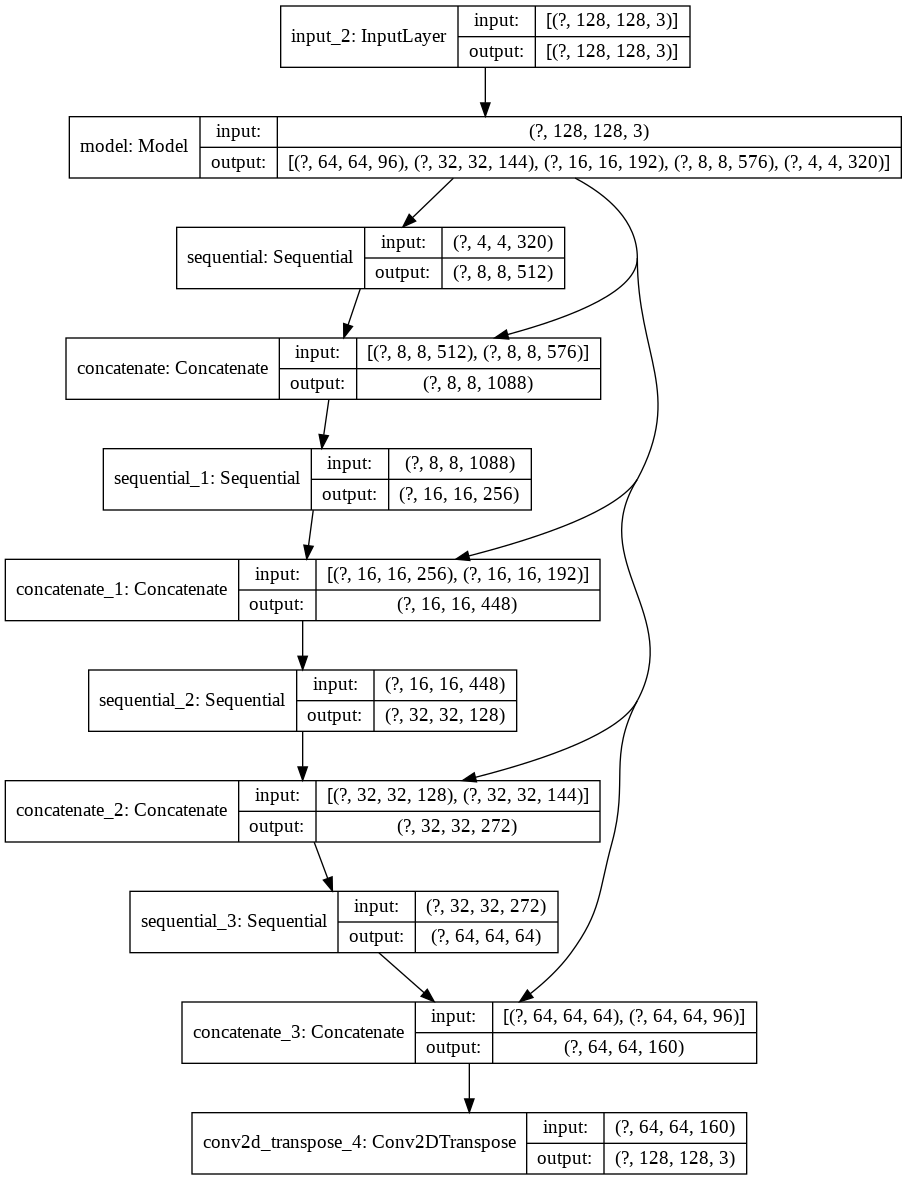

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

Essayons le modèle pour voir ce qu'il prédit avant l'entraînement.

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

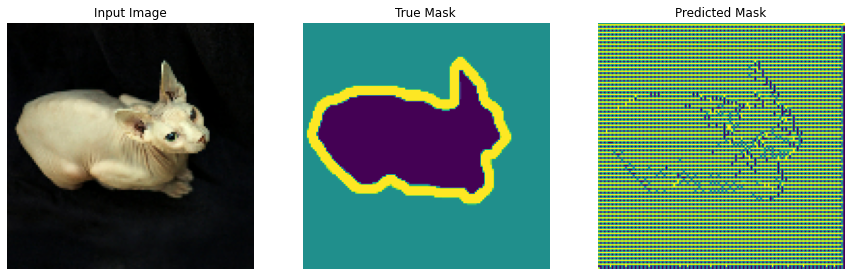

In [0]:
show_predictions()

Observons comment le modèle s'améliore pendant l'entraînement. Pour accomplir cette tâche, une fonction de rappel est définie ci-dessous.

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

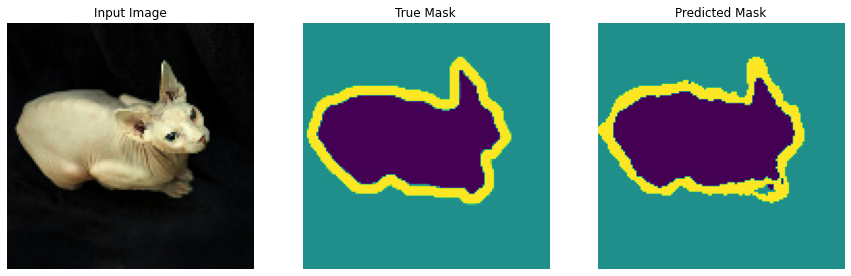


Sample Prediction after epoch 20

57/57 [==============================] - 308s 5s/step - loss: 0.0774 - accuracy: 0.9612 - val_loss: 0.4335 - val_accuracy: 0.8855


In [0]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

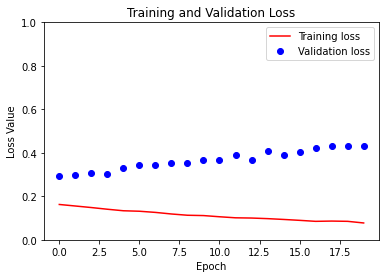

In [0]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

###7.Faire des prédictions

Faisons quelques prédictions. Dans un souci de gain de temps, le nombre d'époques a été réduit, mais vous pouvez le régler plus haut pour obtenir des résultats plus précis.

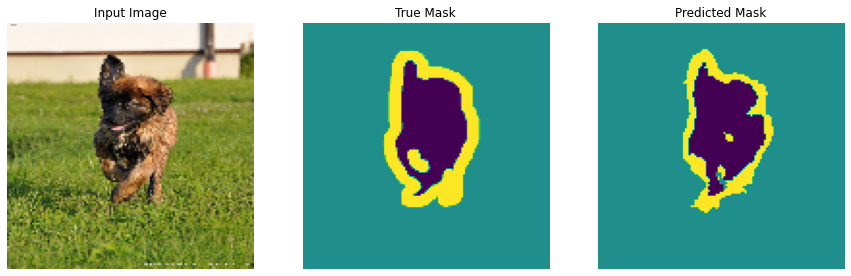

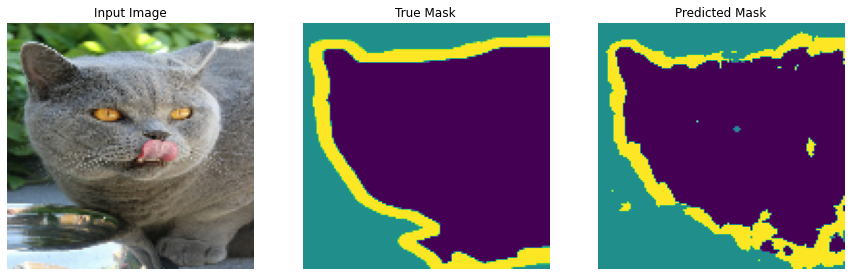

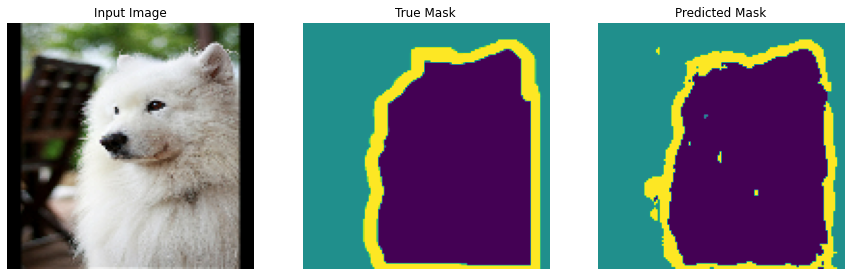

In [0]:
show_predictions(test_dataset, 3)